In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/input-summer22/train.csv
/kaggle/input/input-summer22/test.csv
/kaggle/input/imputed/imputedf.csv
/kaggle/input/imputed/imputed.csv


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import numpy as np
%matplotlib inline

In [13]:
df = pd.read_csv( '/kaggle/input/input-summer22/train.csv' )

In [5]:
df

,id,title,Rating,maincateg,platform,price1,actprice1,Offer %,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,16695,Fashionable & Comfortable Bellies For Women (...,3.9,Women,Flipkart,698,999,30.13%,38.0,7.0,17.0,9.0,6.0,3,3,0
1,5120,Combo Pack of 4 Casual Shoes Sneakers For Men ...,3.8,Men,Flipkart,999,1999,50.03%,531.0,69.0,264.0,92.0,73.0,29,73,1
2,18391,Cilia Mode Leo Sneakers For Women (White),4.4,Women,Flipkart,2749,4999,45.01%,17.0,4.0,11.0,3.0,2.0,1,0,1
3,495,Men Black Sports Sandal,4.2,Men,Flipkart,518,724,15.85%,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,16408,Men Green Sports Sandal,3.9,Men,Flipkart,1379,2299,40.02%,77.0,3.0,35.0,21.0,7.0,7,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15725,16554,Women Maroon Heels Sandal,4.3,Women,Flipkart,567,1199,52.71%,807.0,114.0,485.0,177.0,61.0,41,43,0
15726,19600,Women Multicolor Flats Sandal,3.9,Women,Flipkart,499,998,50.00%,246.0,34.0,120.0,45.0,37.0,16,28,1
15727,6733,Women Navy Flats Sandal,3.7,Women,Flipkart,329,499,34.07%,NaN,18.0,NaN,NaN,20.0,10,15,1
15728,3889,Red Chief Men's Sneakers,3.9,Men,Amazon,2249,4499,50.01%,750.0,479.0,13.0,6.0,10.0,25,47,1


/tmp/ipykernel_32/2606391061.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.drop(['title', 'maincateg', 'platform'], axis='columns').corr(), annot=True)


<AxesSubplot: >

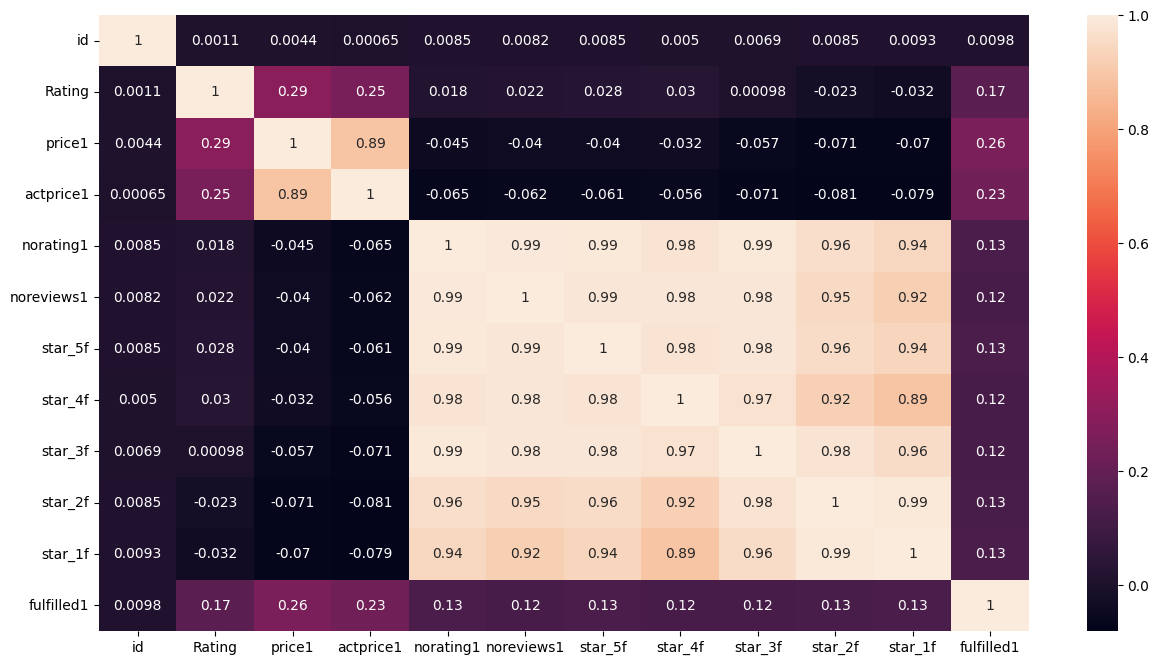

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(df.drop(['title', 'maincateg', 'platform'], axis='columns').corr(), annot=True)

In [14]:
df_target = df[['price1']]
df_id = df[['id']]
df.drop(columns=['id','price1'],inplace=True)

In [8]:
df_Test = pd.read_csv( '/kaggle/input/input-summer22/test.csv' )

In [8]:
df_Test_id = df_Test[['id']]
df_Test.drop(columns=['id'],inplace=True)

In [9]:
df.isnull().sum()

title           0
Rating          0
maincateg     526
platform        0
actprice1       0
Offer %         0
norating1     678
noreviews1    578
star_5f       588
star_4f       539
star_3f       231
star_2f         0
star_1f         0
fulfilled1      0
dtype: int64

In [10]:
df.platform.unique(), df.maincateg.unique() 

(array(['Flipkart', 'Amazon'], dtype=object),
 array(['Women', 'Men', nan], dtype=object))

In [11]:
categorical_features_name = ['maincateg','platform','fulfilled1']
numerical_features_name = list( set(df.columns.values) - set(categorical_features_name) - set(['Offer %','title']) )

In [12]:
df.loc[df['title'].str.upper().str.contains('WOMEN') & df['maincateg'].isnull(), 'maincateg'] = 'Women'
df.loc[df['title'].str.upper().str.contains('MEN') & df['maincateg'].isnull(), 'maincateg'] = 'Men'
df['maincateg'].isnull().sum()

57

In [13]:
df.loc[df['maincateg'].isnull(), 'maincateg'] = 'Unisex'
print(df['maincateg'].isnull().sum())
print(df['maincateg'].unique())

0
['Women' 'Men' 'Unisex']


In [14]:
df.isnull().sum()

title           0
Rating          0
maincateg       0
platform        0
actprice1       0
Offer %         0
norating1     678
noreviews1    578
star_5f       588
star_4f       539
star_3f       231
star_2f         0
star_1f         0
fulfilled1      0
dtype: int64

<AxesSubplot: title={'center': 'norating1 > 10000'}, xlabel='norating1', ylabel='Count'>

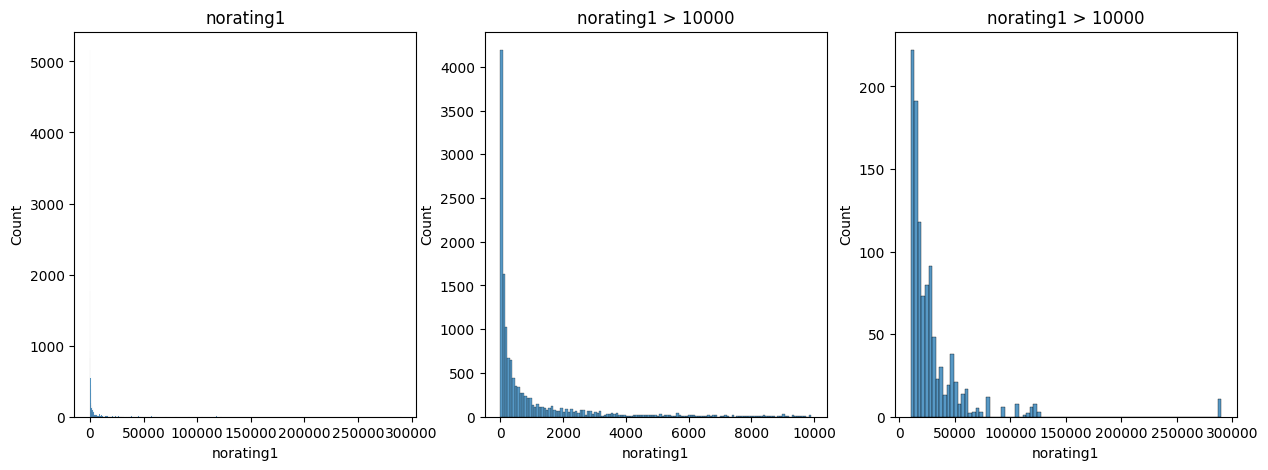

In [15]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('norating1')
sns.histplot(df['norating1'])

plt.subplot(1,3,2)
plt.title('norating1 > 10000')
sns.histplot(df[df['norating1'] < 10000]['norating1'])

plt.subplot(1,3,3)
plt.title('norating1 > 10000')
sns.histplot(df[df['norating1'] > 10000]['norating1'])

In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBRegressor

In [17]:
df

,title,Rating,maincateg,platform,actprice1,Offer %,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,Fashionable & Comfortable Bellies For Women (...,3.9,Women,Flipkart,999,30.13%,38.0,7.0,17.0,9.0,6.0,3,3,0
1,Combo Pack of 4 Casual Shoes Sneakers For Men ...,3.8,Men,Flipkart,1999,50.03%,531.0,69.0,264.0,92.0,73.0,29,73,1
2,Cilia Mode Leo Sneakers For Women (White),4.4,Women,Flipkart,4999,45.01%,17.0,4.0,11.0,3.0,2.0,1,0,1
3,Men Black Sports Sandal,4.2,Men,Flipkart,724,15.85%,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,Men Green Sports Sandal,3.9,Men,Flipkart,2299,40.02%,77.0,3.0,35.0,21.0,7.0,7,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15725,Women Maroon Heels Sandal,4.3,Women,Flipkart,1199,52.71%,807.0,114.0,485.0,177.0,61.0,41,43,0
15726,Women Multicolor Flats Sandal,3.9,Women,Flipkart,998,50.00%,246.0,34.0,120.0,45.0,37.0,16,28,1
15727,Women Navy Flats Sandal,3.7,Women,Flipkart,499,34.07%,NaN,18.0,NaN,NaN,20.0,10,15,1
15728,Red Chief Men's Sneakers,3.9,Men,Amazon,4499,50.01%,750.0,479.0,13.0,6.0,10.0,25,47,1


In [18]:
df=df.drop(columns=['title','Offer %'])

In [19]:
df

,Rating,maincateg,platform,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,3.9,Women,Flipkart,999,38.0,7.0,17.0,9.0,6.0,3,3,0
1,3.8,Men,Flipkart,1999,531.0,69.0,264.0,92.0,73.0,29,73,1
2,4.4,Women,Flipkart,4999,17.0,4.0,11.0,3.0,2.0,1,0,1
3,4.2,Men,Flipkart,724,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,3.9,Men,Flipkart,2299,77.0,3.0,35.0,21.0,7.0,7,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
15725,4.3,Women,Flipkart,1199,807.0,114.0,485.0,177.0,61.0,41,43,0
15726,3.9,Women,Flipkart,998,246.0,34.0,120.0,45.0,37.0,16,28,1
15727,3.7,Women,Flipkart,499,NaN,18.0,NaN,NaN,20.0,10,15,1
15728,3.9,Men,Amazon,4499,750.0,479.0,13.0,6.0,10.0,25,47,1


In [20]:
df1=pd.get_dummies(df[['maincateg','platform']])

In [21]:
df1=df1.drop(columns=['maincateg_Unisex','platform_Flipkart'])

In [22]:
df2=pd.concat([df,df1],axis=1)

In [23]:
df2=df2.drop(columns=['maincateg','platform'])

In [24]:
df2

,Rating,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1,maincateg_Men,maincateg_Women,platform_Amazon
0,3.9,999,38.0,7.0,17.0,9.0,6.0,3,3,0,0,1,0
1,3.8,1999,531.0,69.0,264.0,92.0,73.0,29,73,1,1,0,0
2,4.4,4999,17.0,4.0,11.0,3.0,2.0,1,0,1,0,1,0
3,4.2,724,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1,1,0,0
4,3.9,2299,77.0,3.0,35.0,21.0,7.0,7,7,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15725,4.3,1199,807.0,114.0,485.0,177.0,61.0,41,43,0,0,1,0
15726,3.9,998,246.0,34.0,120.0,45.0,37.0,16,28,1,0,1,0
15727,3.7,499,NaN,18.0,NaN,NaN,20.0,10,15,1,0,1,0
15728,3.9,4499,750.0,479.0,13.0,6.0,10.0,25,47,1,1,0,1


In [25]:
train = pd.read_csv( '/kaggle/input/input-summer22/train.csv' )

In [27]:
imputer = IterativeImputer(estimator=XGBRegressor(n_estimators=2000,tree_method='gpu_hist', predictor="gpu_predictor"),max_iter=20,verbose = 2)
df3 = pd.DataFrame(imputer.fit_transform(df2),columns = df2.columns)

[IterativeImputer] Completing matrix with shape (15730, 13)
[IterativeImputer] Ending imputation round 1/20, elapsed time 39.04
[IterativeImputer] Change: 389001.4484706603, scaled tolerance: 289.973 
[IterativeImputer] Ending imputation round 2/20, elapsed time 76.64
[IterativeImputer] Change: 82042.83203125, scaled tolerance: 289.973 
[IterativeImputer] Ending imputation round 3/20, elapsed time 114.14
[IterativeImputer] Change: 14490.783203125, scaled tolerance: 289.973 
[IterativeImputer] Ending imputation round 4/20, elapsed time 151.57
[IterativeImputer] Change: 12682.720703125, scaled tolerance: 289.973 
[IterativeImputer] Ending imputation round 5/20, elapsed time 189.27
[IterativeImputer] Change: 6527.781982421875, scaled tolerance: 289.973 
[IterativeImputer] Ending imputation round 6/20, elapsed time 227.15
[IterativeImputer] Change: 4201.218505859375, scaled tolerance: 289.973 
[IterativeImputer] Ending imputation round 7/20, elapsed time 264.80
[IterativeImputer] Change: 4

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [28]:
df3.to_csv('imputed.csv')

In [79]:
df3=pd.read_csv('/kaggle/input/imputed/imputed.csv')

In [80]:
df3=df3.drop(columns=['Unnamed: 0'])

In [81]:
df3

,Rating,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1,maincateg_Men,maincateg_Women,platform_Amazon
0,3.9,999.0,38.000000,7.0,17.000000,9.000000,6.0,3.0,3.0,0.0,0.0,1.0,0.0
1,3.8,1999.0,531.000000,69.0,264.000000,92.000000,73.0,29.0,73.0,1.0,1.0,0.0,0.0
2,4.4,4999.0,17.000000,4.0,11.000000,3.000000,2.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.2,724.0,46413.000000,6229.0,1045.000000,12416.000000,5352.0,701.0,4595.0,1.0,1.0,0.0,0.0
4,3.9,2299.0,77.000000,3.0,35.000000,21.000000,7.0,7.0,7.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15725,4.3,1199.0,807.000000,114.0,485.000000,177.000000,61.0,41.0,43.0,0.0,0.0,1.0,0.0
15726,3.9,998.0,246.000000,34.0,120.000000,45.000000,37.0,16.0,28.0,1.0,0.0,1.0,0.0
15727,3.7,499.0,118.999527,18.0,44.559143,24.255184,20.0,10.0,15.0,1.0,0.0,1.0,0.0
15728,3.9,4499.0,750.000000,479.0,13.000000,6.000000,10.0,25.0,47.0,1.0,1.0,0.0,1.0


In [82]:
df3.isnull().sum()

Rating             0
actprice1          0
norating1          0
noreviews1         0
star_5f            0
star_4f            0
star_3f            0
star_2f            0
star_1f            0
fulfilled1         0
maincateg_Men      0
maincateg_Women    0
platform_Amazon    0
dtype: int64

In [83]:
df=pd.concat([df3,train['title']],axis=1)

In [84]:
df.isnull().sum()

Rating             0
actprice1          0
norating1          0
noreviews1         0
star_5f            0
star_4f            0
star_3f            0
star_2f            0
star_1f            0
fulfilled1         0
maincateg_Men      0
maincateg_Women    0
platform_Amazon    0
title              0
dtype: int64

In [85]:
from collections import Counter

arr = []
for i in df['title'].str.split(' '):
    arr += i

c = Counter(arr)    
c_list = c.most_common(100)
c_list

[('For', 10241),
 ('Sandal', 4194),
 ('Shoes', 4163),
 ('Women', 3976),
 ('Running', 2024),
 ('Sneakers', 1806),
 ('Men', 1580),
 ('Black', 1499),
 ('Boots', 1471),
 ('Casual', 1454),
 ('Men\xa0\xa0(Black)', 1454),
 ('Bellies', 1093),
 ('for', 1080),
 ('Jutis', 1073),
 ('Flats', 1054),
 ('Heels', 1008),
 ('Women\xa0\xa0(Black)', 967),
 ('Flip', 894),
 ('Wedges', 875),
 ('Flops', 843),
 ('Stylish', 830),
 ('Walking', 775),
 ('Slip', 711),
 ('Slippers', 679),
 ('On', 663),
 ('Sports', 653),
 ('&', 639),
 ('Slides', 618),
 ('Casuals', 614),
 ('shoes', 593),
 ('Girls', 592),
 ('Women\xa0\xa0(Pink)', 578),
 ('Men\xa0\xa0(Brown)', 529),
 ('|', 505),
 ('Leather', 469),
 ('of', 458),
 ('Mojaris', 458),
 ('Pink', 455),
 ("Men's", 445),
 ('Women\xa0\xa0(Multicolor)', 442),
 ('Lace', 435),
 ('Brown', 435),
 ('Women\xa0\xa0(White)', 432),
 ('and', 430),
 ('Combo', 403),
 ('Grey', 378),
 ('Blue', 371),
 ('Pack', 361),
 ('Women\xa0\xa0(Grey)', 360),
 ('Men\xa0\xa0(Blue)', 356),
 ('High', 351),
 ('La

In [86]:
sp_cols = ['Running','Black', 'Boots', 'Casual', 'Bellies', 'Jutis', 'Flats', 'Heels', 'Wedges', 'Stylish', 'Walking', 'Slip', 'Sports', 'Girls', 'Leather', 'Mojaris', 'Pink', 'Lace', 'Brown', 'Grey', 'Blue', 'Pack', 'Loafers', 'Beige', 'White', 'Red', 'Ethnic', 'Multicolor', 'Formal', 'Tan', 'Synthetic', 'Gold', 'Canvas', 'Party', 'Training', 'IDP', 'Gym', 'Jutti', 'Ankle', 'New', 'Navy', 'Lightweight', 'Derby','combo', 'sandal', 'sneaker', 'shoe', 'chappal']

In [87]:
for cl in sp_cols:
    df[cl] = df['title'].str.upper().str.contains(cl.upper()).astype(int)

In [88]:
df=df.drop(columns=['title'])

In [89]:
df

,Rating,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1,...,Ankle,New,Navy,Lightweight,Derby,combo,sandal,sneaker,shoe,chappal
0,3.9,999.0,38.000000,7.0,17.000000,9.000000,6.0,3.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3.8,1999.0,531.000000,69.0,264.000000,92.000000,73.0,29.0,73.0,1.0,...,0,0,0,0,0,1,0,1,1,0
2,4.4,4999.0,17.000000,4.0,11.000000,3.000000,2.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3,4.2,724.0,46413.000000,6229.0,1045.000000,12416.000000,5352.0,701.0,4595.0,1.0,...,0,0,0,0,0,0,1,0,0,0
4,3.9,2299.0,77.000000,3.0,35.000000,21.000000,7.0,7.0,7.0,1.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15725,4.3,1199.0,807.000000,114.0,485.000000,177.000000,61.0,41.0,43.0,0.0,...,0,0,0,0,0,0,1,0,0,0
15726,3.9,998.0,246.000000,34.0,120.000000,45.000000,37.0,16.0,28.0,1.0,...,0,0,0,0,0,0,1,0,0,0
15727,3.7,499.0,118.999527,18.0,44.559143,24.255184,20.0,10.0,15.0,1.0,...,0,0,1,0,0,0,1,0,0,0
15728,3.9,4499.0,750.000000,479.0,13.000000,6.000000,10.0,25.0,47.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [93]:
df.to_csv('imputedf.csv')

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
model=RandomForestRegressor()

parameters={
    'bootstrap':[False],
    'n_estimators':[200,300,400,250],
    'max_features':[15,20],
    'random_state':[42]
}

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [74]:
selector=GridSearchCV(model,parameters,cv=5)

In [44]:
df

,Rating,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1,...,Party,Training,IDP,Gym,Jutti,Ankle,New,Navy,Lightweight,Derby
0,3.9,999.0,38.000000,7.0,17.000000,9.000000,6.0,3.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3.8,1999.0,531.000000,69.0,264.000000,92.000000,73.0,29.0,73.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,4.4,4999.0,17.000000,4.0,11.000000,3.000000,2.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,4.2,724.0,46413.000000,6229.0,1045.000000,12416.000000,5352.0,701.0,4595.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,3.9,2299.0,77.000000,3.0,35.000000,21.000000,7.0,7.0,7.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15725,4.3,1199.0,807.000000,114.0,485.000000,177.000000,61.0,41.0,43.0,0.0,...,0,0,0,0,0,0,0,0,0,0
15726,3.9,998.0,246.000000,34.0,120.000000,45.000000,37.0,16.0,28.0,1.0,...,0,0,0,0,0,0,0,0,0,0
15727,3.7,499.0,118.999527,18.0,44.559143,24.255184,20.0,10.0,15.0,1.0,...,0,0,0,0,0,0,0,1,0,0
15728,3.9,4499.0,750.000000,479.0,13.000000,6.000000,10.0,25.0,47.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
df_target

,price1
0,698
1,999
2,2749
3,518
4,1379
...,...
15725,567
15726,499
15727,329
15728,2249


In [15]:
labels=df_target['price1']
labels

0         698
1         999
2        2749
3         518
4        1379
         ... 
15725     567
15726     499
15727     329
15728    2249
15729    1539
Name: price1, Length: 15730, dtype: int64

In [75]:
selector.fit(df,labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [False], 'max_features': [15, 20],
                         'n_estimators': [200, 300, 400, 250],
                         'random_state': [42]})

In [76]:
best_params=selector.best_params_
best_params

{'bootstrap': False,
 'max_features': 20,
 'n_estimators': 400,
 'random_state': 42}

In [71]:
selector.cv_results_

{'mean_fit_time': array([ 6.80959959, 10.58479505, 13.84950323, 17.03552575,  8.61449299,
        12.96993518, 17.07895098, 21.58998823, 10.42284136, 15.89887958,
        21.08756809, 26.05804415, 12.16279044, 18.18111339, 24.21330333,
        30.29094324]),
 'std_fit_time': array([0.18991083, 0.29046422, 0.26570534, 0.2704581 , 0.23225519,
        0.26754745, 0.21885082, 0.24388472, 0.24152166, 0.33808736,
        0.31975795, 0.12902089, 0.20857387, 0.20480573, 0.19361371,
        0.11816562]),
 'mean_score_time': array([0.20009437, 0.32411771, 0.42923985, 0.51873598, 0.19951267,
        0.30162406, 0.39526629, 0.49871025, 0.19902172, 0.29916849,
        0.39531007, 0.48076916, 0.20212102, 0.29416442, 0.39036694,
        0.4690352 ]),
 'std_score_time': array([0.00445153, 0.01608331, 0.0358083 , 0.05340544, 0.00228118,
        0.01100641, 0.00325671, 0.0081351 , 0.00193464, 0.01490888,
        0.00526222, 0.00663479, 0.01609476, 0.01298748, 0.01826946,
        0.00660132]),
 'param_ma

In [90]:
model=RandomForestRegressor(n_estimators=400,random_state=42,max_features=20,bootstrap=False)

In [91]:
rfr_scores = cross_val_score(model,df,labels, cv=5, scoring='neg_root_mean_squared_error')
rfr_scores.mean()

-172.97149050290602

In [92]:
rfr_scores

array([-174.02334493, -185.23155449, -172.28402498, -167.66087882,
       -165.6576493 ])

In [8]:
dfxgb = pd.read_csv( '/kaggle/input/imputed/imputedf.csv',index_col=[0])

In [9]:
dfxgb

,Rating,actprice1,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1,...,Ankle,New,Navy,Lightweight,Derby,combo,sandal,sneaker,shoe,chappal
0,3.9,999.0,38.000000,7.0,17.000000,9.000000,6.0,3.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3.8,1999.0,531.000000,69.0,264.000000,92.000000,73.0,29.0,73.0,1.0,...,0,0,0,0,0,1,0,1,1,0
2,4.4,4999.0,17.000000,4.0,11.000000,3.000000,2.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
3,4.2,724.0,46413.000000,6229.0,1045.000000,12416.000000,5352.0,701.0,4595.0,1.0,...,0,0,0,0,0,0,1,0,0,0
4,3.9,2299.0,77.000000,3.0,35.000000,21.000000,7.0,7.0,7.0,1.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15725,4.3,1199.0,807.000000,114.0,485.000000,177.000000,61.0,41.0,43.0,0.0,...,0,0,0,0,0,0,1,0,0,0
15726,3.9,998.0,246.000000,34.0,120.000000,45.000000,37.0,16.0,28.0,1.0,...,0,0,0,0,0,0,1,0,0,0
15727,3.7,499.0,118.999527,18.0,44.559143,24.255184,20.0,10.0,15.0,1.0,...,0,0,1,0,0,0,1,0,0,0
15728,3.9,4499.0,750.000000,479.0,13.000000,6.000000,10.0,25.0,47.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [42]:
model1=XGBRegressor(eta=0.1)

parameters={'alpha':[0.05,0.1,0.3,0.5]
}

In [ ]:
'sub_sample':[1,0.8,0.6,0.3],
    'cosample_bytree':[1,0.8,0.6,0.3],
    'alpha':[0.05,0.1,0.3,0.5]
        'max_depth':[5,9,10,14],
    'n_estimators':[200,300], 
         'min_child_weight':[1,5,6,10]

In [43]:
selector1=GridSearchCV(model1,parameters,cv=5,verbose=3)

In [44]:
selector1.fit(dfxgb,labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ........................alpha=0.05;, score=0.898 total time=   3.2s
[CV 2/5] END ........................alpha=0.05;, score=0.893 total time=   3.2s
[CV 3/5] END ........................alpha=0.05;, score=0.902 total time=   3.2s
[CV 4/5] END ........................alpha=0.05;, score=0.888 total time=   3.4s
[CV 5/5] END ........................alpha=0.05;, score=0.889 total time=   3.2s
[CV 1/5] END .........................alpha=0.1;, score=0.898 total time=   3.2s
[CV 2/5] END .........................alpha=0.1;, score=0.894 total time=   3.4s
[CV 3/5] END .........................alpha=0.1;, score=0.902 total time=   3.2s
[CV 4/5] END .........................alpha=0.1;, score=0.888 total time=   4.2s
[CV 5/5] END .........................alpha=0.1;, score=0.889 total time=   3.4s
[CV 1/5] END .........................alpha=0.3;, score=0.896 total time=   3.3s
[CV 2/5] END .........................alpha=0.3;,

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.1,
                                    eval_metric=None, feature_types=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, ...),
             param_grid={'alpha': [0.05, 0.1, 0.3, 0.5]}, verbose=3)

In [45]:
best_params1=selector1.best_params_
best_params1

{'alpha': 0.1}

In [56]:
model1=XGBRegressor(eta=0.1,max_depth= 9, min_child_weight= 1, n_estimators= 500,colsample_bytree=1,subsample= 0.8,alpha=0.1)

In [57]:
xgb_scores = cross_val_score(model1,dfxgb,labels, cv=5, scoring='neg_root_mean_squared_error')
xgb_scores.mean()

-176.3432039728169

In [53]:
dfxg_less=dfxgb.drop(columns=['norating1','noreviews1','star_4f','star_3f','star_2f','star_1f'])

In [54]:
dfxg_less

,Rating,actprice1,star_5f,fulfilled1,maincateg_Men,maincateg_Women,platform_Amazon,Running,Black,Boots,...,Ankle,New,Navy,Lightweight,Derby,combo,sandal,sneaker,shoe,chappal
0,3.9,999.0,17.000000,0.0,0.0,1.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.8,1999.0,264.000000,1.0,1.0,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
2,4.4,4999.0,11.000000,1.0,0.0,1.0,0.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4.2,724.0,1045.000000,1.0,1.0,0.0,0.0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3.9,2299.0,35.000000,1.0,1.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15725,4.3,1199.0,485.000000,0.0,0.0,1.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
15726,3.9,998.0,120.000000,1.0,0.0,1.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
15727,3.7,499.0,44.559143,1.0,0.0,1.0,0.0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
15728,3.9,4499.0,13.000000,1.0,1.0,0.0,1.0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
